```@meta
CurrentModule = AlgorithmicRecourse 
```

# From cat to dog

In [161]:
using Plots, AlgorithmicRecourse, Random
using Logging
disable_logging(Logging.Info)

LogLevel(1)

In [162]:
retrain = true
include("CIFAR10.jl")

Training loss


avg_loss(data) = 0.6825474f0
Training accuracy


accuracy(train_x, train_y) = 0.5454444444444444
Test accuracy


accuracy(val_x, val_y) = 0.552


Training loss


avg_loss(data) = 0.67651486f0
Training accuracy


accuracy(train_x, train_y) = 0.574
Test accuracy


accuracy(val_x, val_y) = 0.564


Training loss


avg_loss(data) = 0.6727616f0
Training accuracy


accuracy(train_x, train_y) = 0.5798888888888889
Test accuracy


accuracy(val_x, val_y) = 0.565


Training loss


avg_loss(data) = 0.67103076f0
Training accuracy


accuracy(train_x, train_y) = 0.578
Test accuracy


accuracy(val_x, val_y) = 0.558


Training loss


avg_loss(data) = 0.6684306f0
Training accuracy


accuracy(train_x, train_y) = 0.5835555555555556
Test accuracy


accuracy(val_x, val_y) = 0.568


Training loss


avg_loss(data) = 0.6642725f0
Training accuracy


accuracy(train_x, train_y) = 0.6011111111111112
Test accuracy


accuracy(val_x, val_y) = 0.584


Training loss


avg_loss(data) = 0.66158307f0
Training accuracy


accuracy(train_x, train_y) = 0.605
Test accuracy


accuracy(val_x, val_y) = 0.598


Training loss


avg_loss(data) = 0.65961385f0
Training accuracy


accuracy(train_x, train_y) = 0.6057777777777777
Test accuracy


accuracy(val_x, val_y) = 0.597


Training loss


avg_loss(data) = 0.65797454f0
Training accuracy


accuracy(train_x, train_y) = 0.6095555555555555
Test accuracy


accuracy(val_x, val_y) = 0.598


Training loss


avg_loss(data) = 0.65596473f0
Training accuracy


accuracy(train_x, train_y) = 0.6106666666666667
Test accuracy


accuracy(val_x, val_y) = 0.597


Training loss


avg_loss(data) = 0.6535014f0
Training accuracy


accuracy(train_x, train_y) = 0.6127777777777778
Test accuracy


accuracy(val_x, val_y) = 0.609


Training loss


avg_loss(data) = 0.6511977f0
Training accuracy


accuracy(train_x, train_y) = 0.6154444444444445
Test accuracy


accuracy(val_x, val_y) = 0.614


Training loss


avg_loss(data) = 0.6498718f0
Training accuracy


accuracy(train_x, train_y) = 0.6187777777777778
Test accuracy


accuracy(val_x, val_y) = 0.613


Training loss


avg_loss(data) = 0.64821625f0
Training accuracy


accuracy(train_x, train_y) = 0.6196666666666667
Test accuracy


accuracy(val_x, val_y) = 0.612


Training loss


avg_loss(data) = 0.64722216f0
Training accuracy


accuracy(train_x, train_y) = 0.6197777777777778
Test accuracy


accuracy(val_x, val_y) = 0.611


Training loss


avg_loss(data) = 0.6454185f0
Training accuracy


accuracy(train_x, train_y) = 0.6226666666666667
Test accuracy


accuracy(val_x, val_y) = 0.61


Training loss


avg_loss(data) = 0.6441344f0
Training accuracy


accuracy(train_x, train_y) = 0.6237777777777778
Test accuracy


accuracy(val_x, val_y) = 0.608


Training loss


avg_loss(data) = 0.6420594f0
Training accuracy


accuracy(train_x, train_y) = 0.6262222222222222
Test accuracy


accuracy(val_x, val_y) = 0.614


Training loss


avg_loss(data) = 0.6400754f0
Training accuracy


accuracy(train_x, train_y) = 0.6291111111111111
Test accuracy


accuracy(val_x, val_y) = 0.611


Training loss


avg_loss(data) = 0.6379264f0
Training accuracy


accuracy(train_x, train_y) = 0.6307777777777778
Test accuracy


accuracy(val_x, val_y) = 0.616


Training loss


avg_loss(data) = 0.63596666f0
Training accuracy


accuracy(train_x, train_y) = 0.6327777777777778
Test accuracy


accuracy(val_x, val_y) = 0.622


Training loss


avg_loss(data) = 0.633887f0
Training accuracy


accuracy(train_x, train_y) = 0.6343333333333333
Test accuracy


accuracy(val_x, val_y) = 0.624


Training loss


avg_loss(data) = 0.6316375f0
Training accuracy


accuracy(train_x, train_y) = 0.6378888888888888
Test accuracy


accuracy(val_x, val_y) = 0.625


Training loss


avg_loss(data) = 0.62976927f0
Training accuracy


accuracy(train_x, train_y) = 0.6388888888888888
Test accuracy


accuracy(val_x, val_y) = 0.627


Training loss


avg_loss(data) = 0.6265178f0
Training accuracy


accuracy(train_x, train_y) = 0.6433333333333333
Test accuracy


accuracy(val_x, val_y) = 0.626


Training loss


avg_loss(data) = 0.62418544f0
Training accuracy


accuracy(train_x, train_y) = 0.646
Test accuracy


accuracy(val_x, val_y) = 0.632


Training loss


avg_loss(data) = 0.6210043f0
Training accuracy


accuracy(train_x, train_y) = 0.6497777777777778
Test accuracy


accuracy(val_x, val_y) = 0.637


Training loss


avg_loss(data) = 0.6186775f0
Training accuracy


accuracy(train_x, train_y) = 0.6501111111111111
Test accuracy


accuracy(val_x, val_y) = 0.634


Training loss


avg_loss(data) = 0.6152058f0
Training accuracy


accuracy(train_x, train_y) = 0.6573333333333333
Test accuracy


accuracy(val_x, val_y) = 0.642


Training loss


avg_loss(data) = 0.6123416f0
Training accuracy


accuracy(train_x, train_y) = 0.6626666666666666
Test accuracy


accuracy(val_x, val_y) = 0.649


Training loss


avg_loss(data) = 0.60956544f0
Training accuracy


accuracy(train_x, train_y) = 0.6643333333333333
Test accuracy


accuracy(val_x, val_y) = 0.651


Training loss


avg_loss(data) = 0.60652244f0
Training accuracy


accuracy(train_x, train_y) = 0.6694444444444444
Test accuracy


accuracy(val_x, val_y) = 0.656


Training loss


avg_loss(data) = 0.60367805f0
Training accuracy


accuracy(train_x, train_y) = 0.673
Test accuracy


accuracy(val_x, val_y) = 0.657


Training loss


avg_loss(data) = 0.60096174f0
Training accuracy


accuracy(train_x, train_y) = 0.6733333333333333
Test accuracy


accuracy(val_x, val_y) = 0.653


Training loss


avg_loss(data) = 0.59827495f0
Training accuracy


accuracy(train_x, train_y) = 0.6778888888888889
Test accuracy


accuracy(val_x, val_y) = 0.653


Training loss


avg_loss(data) = 0.5952866f0
Training accuracy


accuracy(train_x, train_y) = 0.6813333333333333
Test accuracy


accuracy(val_x, val_y) = 0.666


Training loss


avg_loss(data) = 0.5927047f0
Training accuracy


accuracy(train_x, train_y) = 0.6836666666666666
Test accuracy


accuracy(val_x, val_y) = 0.667


Training loss


avg_loss(data) = 0.58970827f0
Training accuracy


accuracy(train_x, train_y) = 0.6876666666666666
Test accuracy


accuracy(val_x, val_y) = 0.669


Training loss


avg_loss(data) = 0.58593684f0
Training accuracy


accuracy(train_x, train_y) = 0.6913333333333334
Test accuracy


accuracy(val_x, val_y) = 0.67


Training loss


avg_loss(data) = 0.5815191f0
Training accuracy


accuracy(train_x, train_y) = 0.6935555555555556
Test accuracy


accuracy(val_x, val_y) = 0.665


Training loss


avg_loss(data) = 0.5784434f0
Training accuracy


accuracy(train_x, train_y) = 0.6946666666666667
Test accuracy


accuracy(val_x, val_y) = 0.67


Training loss


avg_loss(data) = 0.576957f0
Training accuracy


accuracy(train_x, train_y) = 0.6991111111111111
Test accuracy


accuracy(val_x, val_y) = 0.671


Training loss


avg_loss(data) = 0.57539487f0
Training accuracy


accuracy(train_x, train_y) = 0.702
Test accuracy


accuracy(val_x, val_y) = 0.679


Training loss


avg_loss(data) = 0.5723451f0
Training accuracy


accuracy(train_x, train_y) = 0.7037777777777777
Test accuracy


accuracy(val_x, val_y) = 0.681


Training loss


avg_loss(data) = 0.56888694f0
Training accuracy


accuracy(train_x, train_y) = 0.704
Test accuracy


accuracy(val_x, val_y) = 0.68


Training loss


avg_loss(data) = 0.5668952f0
Training accuracy


accuracy(train_x, train_y) = 0.7028888888888889
Test accuracy


accuracy(val_x, val_y) = 0.68


Training loss


avg_loss(data) = 0.5682556f0
Training accuracy


accuracy(train_x, train_y) = 0.7008888888888889
Test accuracy


accuracy(val_x, val_y) = 0.676


Training loss


avg_loss(data) = 0.57240564f0
Training accuracy


accuracy(train_x, train_y) = 0.6978888888888889
Test accuracy


accuracy(val_x, val_y) = 0.678


Training loss


avg_loss(data) = 0.57659715f0
Training accuracy


accuracy(train_x, train_y) = 0.6953333333333334
Test accuracy


accuracy(val_x, val_y) = 0.679


Training loss


avg_loss(data) = 0.57132995f0
Training accuracy


accuracy(train_x, train_y) = 0.7008888888888889
Test accuracy


accuracy(val_x, val_y) = 0.683


Training loss


avg_loss(data) = 0.55926585f0
Training accuracy


accuracy(train_x, train_y) = 0.7073333333333334
Test accuracy


accuracy(val_x, val_y) = 0.69


Training loss


avg_loss(data) = 0.5528214f0
Training accuracy


accuracy(train_x, train_y) = 0.7118888888888889
Test accuracy


accuracy(val_x, val_y) = 0.699


Training loss


avg_loss(data) = 0.5516312f0
Training accuracy


accuracy(train_x, train_y) = 0.712
Test accuracy


accuracy(val_x, val_y) = 0.702


Training loss


avg_loss(data) = 0.5514117f0
Training accuracy


accuracy(train_x, train_y) = 0.7098888888888889
Test accuracy


accuracy(val_x, val_y) = 0.698


Training loss


avg_loss(data) = 0.5484749f0
Training accuracy


accuracy(train_x, train_y) = 0.714
Test accuracy


accuracy(val_x, val_y) = 0.701


Training loss


avg_loss(data) = 0.5472001f0
Training accuracy


accuracy(train_x, train_y) = 0.7135555555555556
Test accuracy


accuracy(val_x, val_y) = 0.701


Training loss


avg_loss(data) = 0.54556966f0
Training accuracy


accuracy(train_x, train_y) = 0.7151111111111111
Test accuracy


accuracy(val_x, val_y) = 0.698


Training loss


avg_loss(data) = 0.5480826f0
Training accuracy


accuracy(train_x, train_y) = 0.7137777777777777
Test accuracy


accuracy(val_x, val_y) = 0.691


Training loss


avg_loss(data) = 0.54982746f0
Training accuracy


accuracy(train_x, train_y) = 0.7136666666666667
Test accuracy


accuracy(val_x, val_y) = 0.69


Training loss


avg_loss(data) = 0.54872894f0
Training accuracy


accuracy(train_x, train_y) = 0.7144444444444444
Test accuracy


accuracy(val_x, val_y) = 0.689


Training loss


avg_loss(data) = 0.5458472f0
Training accuracy


accuracy(train_x, train_y) = 0.7166666666666667
Test accuracy


accuracy(val_x, val_y) = 0.691


Training loss


avg_loss(data) = 0.5426929f0
Training accuracy


accuracy(train_x, train_y) = 0.7211111111111111
Test accuracy


accuracy(val_x, val_y) = 0.694


Training loss


avg_loss(data) = 0.5410088f0
Training accuracy


accuracy(train_x, train_y) = 0.7205555555555555
Test accuracy


accuracy(val_x, val_y) = 0.697


Training loss


avg_loss(data) = 0.5394941f0
Training accuracy


accuracy(train_x, train_y) = 0.7206666666666667
Test accuracy


accuracy(val_x, val_y) = 0.703


Training loss


avg_loss(data) = 0.53768724f0
Training accuracy


accuracy(train_x, train_y) = 0.7216666666666667
Test accuracy


accuracy(val_x, val_y) = 0.699


Training loss


avg_loss(data) = 0.5383284f0
Training accuracy


accuracy(train_x, train_y) = 0.7205555555555555
Test accuracy


accuracy(val_x, val_y) = 0.7


Training loss


avg_loss(data) = 0.5365827f0
Training accuracy


accuracy(train_x, train_y) = 0.7224444444444444
Test accuracy


accuracy(val_x, val_y) = 0.702


Training loss


avg_loss(data) = 0.53308606f0
Training accuracy


accuracy(train_x, train_y) = 0.7266666666666667
Test accuracy


accuracy(val_x, val_y) = 0.705


Training loss


avg_loss(data) = 0.52994514f0
Training accuracy


accuracy(train_x, train_y) = 0.729
Test accuracy


accuracy(val_x, val_y) = 0.702


Training loss


avg_loss(data) = 0.5282207f0
Training accuracy


accuracy(train_x, train_y) = 0.7306666666666667
Test accuracy


accuracy(val_x, val_y) = 0.702


Training loss


avg_loss(data) = 0.52736056f0
Training accuracy


accuracy(train_x, train_y) = 0.7282222222222222
Test accuracy


accuracy(val_x, val_y) = 0.706


Training loss


avg_loss(data) = 0.53005f0
Training accuracy


accuracy(train_x, train_y) = 0.7242222222222222
Test accuracy


accuracy(val_x, val_y) = 0.702


Training loss


avg_loss(data) = 0.5185888f0
Training accuracy


accuracy(train_x, train_y) = 0.7351111111111112
Test accuracy


accuracy(val_x, val_y) = 0.708


Training loss


avg_loss(data) = 0.5137688f0
Training accuracy


accuracy(train_x, train_y) = 0.7403333333333333
Test accuracy


accuracy(val_x, val_y) = 0.71


Training loss


avg_loss(data) = 0.51989627f0
Training accuracy


accuracy(train_x, train_y) = 0.7351111111111112
Test accuracy


accuracy(val_x, val_y) = 0.706


Training loss


avg_loss(data) = 0.52027184f0
Training accuracy


accuracy(train_x, train_y) = 0.7382222222222222
Test accuracy


accuracy(val_x, val_y) = 0.704


Training loss


avg_loss(data) = 0.52923703f0
Training accuracy


accuracy(train_x, train_y) = 0.7317777777777777
Test accuracy


accuracy(val_x, val_y) = 0.696


Training loss


avg_loss(data) = 0.5204903f0
Training accuracy


accuracy(train_x, train_y) = 0.7386666666666667
Test accuracy


accuracy(val_x, val_y) = 0.704


Training loss


avg_loss(data) = 0.51445466f0
Training accuracy


accuracy(train_x, train_y) = 0.7405555555555555
Test accuracy


accuracy(val_x, val_y) = 0.711


Training loss


avg_loss(data) = 0.51518977f0
Training accuracy


accuracy(train_x, train_y) = 0.7407777777777778
Test accuracy


accuracy(val_x, val_y) = 0.711


Training loss


avg_loss(data) = 0.51787776f0
Training accuracy


accuracy(train_x, train_y) = 0.7362222222222222
Test accuracy


accuracy(val_x, val_y) = 0.711


Training loss


avg_loss(data) = 0.5086073f0
Training accuracy


accuracy(train_x, train_y) = 0.743
Test accuracy


accuracy(val_x, val_y) = 0.714


Training loss


avg_loss(data) = 0.50300014f0
Training accuracy


accuracy(train_x, train_y) = 0.7475555555555555
Test accuracy


accuracy(val_x, val_y) = 0.717


Training loss


avg_loss(data) = 0.5094111f0
Training accuracy


accuracy(train_x, train_y) = 0.7438888888888889
Test accuracy


accuracy(val_x, val_y) = 0.706


Training loss


avg_loss(data) = 0.51804763f0
Training accuracy


accuracy(train_x, train_y) = 0.7385555555555555
Test accuracy


accuracy(val_x, val_y) = 0.701


Training loss


avg_loss(data) = 0.5154469f0
Training accuracy


accuracy(train_x, train_y) = 0.7422222222222222
Test accuracy


accuracy(val_x, val_y) = 0.704


Training loss


avg_loss(data) = 0.5135963f0
Training accuracy


accuracy(train_x, train_y) = 0.741
Test accuracy


accuracy(val_x, val_y) = 0.703


Training loss


avg_loss(data) = 0.49789396f0
Training accuracy


accuracy(train_x, train_y) = 0.7543333333333333
Test accuracy


accuracy(val_x, val_y) = 0.715


Training loss


avg_loss(data) = 0.49110115f0
Training accuracy


accuracy(train_x, train_y) = 0.7616666666666667
Test accuracy


accuracy(val_x, val_y) = 0.721


Training loss


avg_loss(data) = 0.49077293f0
Training accuracy


accuracy(train_x, train_y) = 0.7597777777777778
Test accuracy


accuracy(val_x, val_y) = 0.72


Training loss


avg_loss(data) = 0.48959494f0
Training accuracy


accuracy(train_x, train_y) = 0.7638888888888888
Test accuracy


accuracy(val_x, val_y) = 0.718


Training loss


avg_loss(data) = 0.488203f0
Training accuracy


accuracy(train_x, train_y) = 0.7623333333333333
Test accuracy


accuracy(val_x, val_y) = 0.717


Training loss


avg_loss(data) = 0.48874936f0
Training accuracy


accuracy(train_x, train_y) = 0.7633333333333333
Test accuracy


accuracy(val_x, val_y) = 0.716


Training loss


avg_loss(data) = 0.49037328f0
Training accuracy


accuracy(train_x, train_y) = 0.7638888888888888
Test accuracy


accuracy(val_x, val_y) = 0.717


Training loss


avg_loss(data) = 0.48382506f0
Training accuracy


accuracy(train_x, train_y) = 0.768
Test accuracy


accuracy(val_x, val_y) = 0.721


Training loss


avg_loss(data) = 0.48042285f0
Training accuracy


accuracy(train_x, train_y) = 0.7698888888888888
Test accuracy


accuracy(val_x, val_y) = 0.723


Training loss


avg_loss(data) = 0.4778373f0
Training accuracy


accuracy(train_x, train_y) = 0.7733333333333333
Test accuracy


accuracy(val_x, val_y) = 0.725


Training loss


avg_loss(data) = 0.47624412f0
Training accuracy


accuracy(train_x, train_y) = 0.7726666666666666
Test accuracy


accuracy(val_x, val_y) = 0.724


Training loss


avg_loss(data) = 0.4734453f0
Training accuracy


accuracy(train_x, train_y) = 0.7762222222222223
Test accuracy


accuracy(val_x, val_y) = 0.717


Training loss


avg_loss(data) = 0.47111738f0
Training accuracy


accuracy(train_x, train_y) = 0.778
Test accuracy


accuracy(val_x, val_y) = 0.724


Training loss


avg_loss(data) = 0.470847f0
Training accuracy


accuracy(train_x, train_y) = 0.777
Test accuracy


accuracy(val_x, val_y) = 0.724


Training loss


avg_loss(data) = 0.46832004f0
Training accuracy


accuracy(train_x, train_y) = 0.7766666666666666
Test accuracy


accuracy(val_x, val_y) = 0.723


Training loss


avg_loss(data) = 0.469688f0
Training accuracy


accuracy(train_x, train_y) = 0.7788888888888889
Test accuracy


accuracy(val_x, val_y) = 0.725


Training loss


avg_loss(data) = 0.4646721f0
Training accuracy


accuracy(train_x, train_y) = 0.7793333333333333
Test accuracy


accuracy(val_x, val_y) = 0.725


Training loss


avg_loss(data) = 0.46209526f0
Training accuracy


accuracy(train_x, train_y) = 0.7831111111111111
Test accuracy


accuracy(val_x, val_y) = 0.726


Training loss


avg_loss(data) = 0.46108913f0
Training accuracy


accuracy(train_x, train_y) = 0.7817777777777778
Test accuracy


accuracy(val_x, val_y) = 0.731


Training loss


avg_loss(data) = 0.4608283f0
Training accuracy


accuracy(train_x, train_y) = 0.7802222222222223
Test accuracy


accuracy(val_x, val_y) = 0.727


Training loss


avg_loss(data) = 0.45967504f0
Training accuracy


accuracy(train_x, train_y) = 0.783
Test accuracy


accuracy(val_x, val_y) = 0.731


Training loss


avg_loss(data) = 0.46048546f0
Training accuracy


accuracy(train_x, train_y) = 0.7802222222222223
Test accuracy


accuracy(val_x, val_y) = 0.725


Training loss


avg_loss(data) = 0.4593817f0
Training accuracy


accuracy(train_x, train_y) = 0.784
Test accuracy


accuracy(val_x, val_y) = 0.724


Training loss


avg_loss(data) = 0.4624406f0
Training accuracy


accuracy(train_x, train_y) = 0.7785555555555556
Test accuracy


accuracy(val_x, val_y) = 0.727


Training loss


avg_loss(data) = 0.45800072f0
Training accuracy


accuracy(train_x, train_y) = 0.7847777777777778
Test accuracy


accuracy(val_x, val_y) = 0.721


Training loss


avg_loss(data) = 0.45108998f0
Training accuracy


accuracy(train_x, train_y) = 0.7874444444444444
Test accuracy


accuracy(val_x, val_y) = 0.727


Training loss


avg_loss(data) = 0.4518276f0
Training accuracy


accuracy(train_x, train_y) = 0.7871111111111111
Test accuracy


accuracy(val_x, val_y) = 0.727


Training loss


avg_loss(data) = 0.45313862f0
Training accuracy


accuracy(train_x, train_y) = 0.7871111111111111
Test accuracy


accuracy(val_x, val_y) = 0.731


Training loss


avg_loss(data) = 0.45225397f0
Training accuracy


accuracy(train_x, train_y) = 0.7873333333333333
Test accuracy


accuracy(val_x, val_y) = 0.728


Training loss


avg_loss(data) = 0.45270646f0
Training accuracy


accuracy(train_x, train_y) = 0.7858888888888889
Test accuracy


accuracy(val_x, val_y) = 0.728


Training loss


avg_loss(data) = 0.44883573f0
Training accuracy


accuracy(train_x, train_y) = 0.7874444444444444
Test accuracy


accuracy(val_x, val_y) = 0.731


Training loss


avg_loss(data) = 0.44915327f0
Training accuracy


accuracy(train_x, train_y) = 0.7864444444444444
Test accuracy


accuracy(val_x, val_y) = 0.727


Training loss


avg_loss(data) = 0.4404439f0
Training accuracy


accuracy(train_x, train_y) = 0.7932222222222223
Test accuracy


accuracy(val_x, val_y) = 0.732


Training loss


avg_loss(data) = 0.43992132f0
Training accuracy


accuracy(train_x, train_y) = 0.795
Test accuracy


accuracy(val_x, val_y) = 0.726


Training loss


avg_loss(data) = 0.44246712f0
Training accuracy


accuracy(train_x, train_y) = 0.792
Test accuracy


accuracy(val_x, val_y) = 0.736


Training loss


avg_loss(data) = 0.4393786f0
Training accuracy


accuracy(train_x, train_y) = 0.7955555555555556
Test accuracy


accuracy(val_x, val_y) = 0.733


Training loss


avg_loss(data) = 0.4391896f0
Training accuracy


accuracy(train_x, train_y) = 0.795
Test accuracy


accuracy(val_x, val_y) = 0.731


Training loss


avg_loss(data) = 0.43607754f0
Training accuracy


accuracy(train_x, train_y) = 0.7972222222222223
Test accuracy


accuracy(val_x, val_y) = 0.725


Training loss


avg_loss(data) = 0.43243492f0
Training accuracy


accuracy(train_x, train_y) = 0.8011111111111111
Test accuracy


accuracy(val_x, val_y) = 0.733


Training loss


avg_loss(data) = 0.43062016f0
Training accuracy


accuracy(train_x, train_y) = 0.8012222222222222
Test accuracy


accuracy(val_x, val_y) = 0.737


Training loss


avg_loss(data) = 0.4298821f0
Training accuracy


accuracy(train_x, train_y) = 0.8011111111111111
Test accuracy


accuracy(val_x, val_y) = 0.735


Training loss


avg_loss(data) = 0.43401992f0
Training accuracy


accuracy(train_x, train_y) = 0.7985555555555556
Test accuracy


accuracy(val_x, val_y) = 0.731


Training loss


avg_loss(data) = 0.43449435f0
Training accuracy


accuracy(train_x, train_y) = 0.7957777777777778
Test accuracy


accuracy(val_x, val_y) = 0.733


Training loss


avg_loss(data) = 0.4358649f0
Training accuracy


accuracy(train_x, train_y) = 0.7966666666666666
Test accuracy


accuracy(val_x, val_y) = 0.741


Training loss


avg_loss(data) = 0.4322449f0
Training accuracy


accuracy(train_x, train_y) = 0.7987777777777778
Test accuracy


accuracy(val_x, val_y) = 0.735


Training loss


avg_loss(data) = 0.42734262f0
Training accuracy


accuracy(train_x, train_y) = 0.7996666666666666
Test accuracy


accuracy(val_x, val_y) = 0.735


Training loss


avg_loss(data) = 0.43692446f0
Training accuracy


accuracy(train_x, train_y) = 0.7935555555555556
Test accuracy


accuracy(val_x, val_y) = 0.724


Training loss


avg_loss(data) = 0.42303112f0
Training accuracy


accuracy(train_x, train_y) = 0.8057777777777778
Test accuracy


accuracy(val_x, val_y) = 0.727


Training loss


avg_loss(data) = 0.4199823f0
Training accuracy


accuracy(train_x, train_y) = 0.8053333333333333
Test accuracy


accuracy(val_x, val_y) = 0.73


Training loss


avg_loss(data) = 0.42188278f0
Training accuracy


accuracy(train_x, train_y) = 0.8017777777777778
Test accuracy


accuracy(val_x, val_y) = 0.723


Training loss


avg_loss(data) = 0.41894913f0
Training accuracy


accuracy(train_x, train_y) = 0.8071111111111111
Test accuracy


accuracy(val_x, val_y) = 0.731


Training loss


avg_loss(data) = 0.4185024f0
Training accuracy


accuracy(train_x, train_y) = 0.8084444444444444
Test accuracy


accuracy(val_x, val_y) = 0.732


Training loss


avg_loss(data) = 0.43199775f0
Training accuracy


accuracy(train_x, train_y) = 0.7962222222222223
Test accuracy


accuracy(val_x, val_y) = 0.726


Training loss


avg_loss(data) = 0.41896236f0
Training accuracy


accuracy(train_x, train_y) = 0.8054444444444444
Test accuracy


accuracy(val_x, val_y) = 0.736


Training loss


avg_loss(data) = 0.417538f0
Training accuracy


accuracy(train_x, train_y) = 0.8053333333333333
Test accuracy


accuracy(val_x, val_y) = 0.737


Training loss


avg_loss(data) = 0.4175608f0
Training accuracy


accuracy(train_x, train_y) = 0.8073333333333333
Test accuracy


accuracy(val_x, val_y) = 0.733


Training loss


avg_loss(data) = 0.41768366f0
Training accuracy


accuracy(train_x, train_y) = 0.8061111111111111
Test accuracy


accuracy(val_x, val_y) = 0.745


Training loss


avg_loss(data) = 0.40935716f0
Training accuracy


accuracy(train_x, train_y) = 0.814
Test accuracy


accuracy(val_x, val_y) = 0.738


Training loss


avg_loss(data) = 0.41493723f0
Training accuracy


accuracy(train_x, train_y) = 0.8078888888888889
Test accuracy


accuracy(val_x, val_y) = 0.736


Training loss


avg_loss(data) = 0.42449567f0
Training accuracy


accuracy(train_x, train_y) = 0.8027777777777778
Test accuracy


accuracy(val_x, val_y) = 0.722


Training loss


avg_loss(data) = 0.41900524f0
Training accuracy


accuracy(train_x, train_y) = 0.8055555555555556
Test accuracy


accuracy(val_x, val_y) = 0.73


Training loss


avg_loss(data) = 0.42509887f0
Training accuracy


accuracy(train_x, train_y) = 0.8023333333333333
Test accuracy


accuracy(val_x, val_y) = 0.737


Training loss


avg_loss(data) = 0.40694803f0
Training accuracy


accuracy(train_x, train_y) = 0.813
Test accuracy


accuracy(val_x, val_y) = 0.729


Training loss


avg_loss(data) = 0.4087513f0
Training accuracy


accuracy(train_x, train_y) = 0.8122222222222222
Test accuracy


accuracy(val_x, val_y) = 0.731


Training loss


avg_loss(data) = 0.41095382f0
Training accuracy


accuracy(train_x, train_y) = 0.8094444444444444
Test accuracy


accuracy(val_x, val_y) = 0.73


Training loss


avg_loss(data) = 0.40573502f0
Training accuracy


accuracy(train_x, train_y) = 0.8141111111111111
Test accuracy


accuracy(val_x, val_y) = 0.725


Training loss


avg_loss(data) = 0.42271015f0
Training accuracy


accuracy(train_x, train_y) = 0.8026666666666666
Test accuracy


accuracy(val_x, val_y) = 0.722


Training loss


avg_loss(data) = 0.39778602f0
Training accuracy


accuracy(train_x, train_y) = 0.8196666666666667
Test accuracy


accuracy(val_x, val_y) = 0.728


Training loss


avg_loss(data) = 0.39503968f0
Training accuracy


accuracy(train_x, train_y) = 0.8208888888888889
Test accuracy


accuracy(val_x, val_y) = 0.721


Training loss


avg_loss(data) = 0.40292406f0
Training accuracy


accuracy(train_x, train_y) = 0.8137777777777778
Test accuracy


accuracy(val_x, val_y) = 0.719


Training loss


avg_loss(data) = 0.3995719f0
Training accuracy


accuracy(train_x, train_y) = 0.8162222222222222
Test accuracy


accuracy(val_x, val_y) = 0.733


Training loss


avg_loss(data) = 0.393608f0
Training accuracy


accuracy(train_x, train_y) = 0.8211111111111111
Test accuracy


accuracy(val_x, val_y) = 0.725


Training loss


avg_loss(data) = 0.40973717f0
Training accuracy


accuracy(train_x, train_y) = 0.8085555555555556
Test accuracy


accuracy(val_x, val_y) = 0.725


Training loss


avg_loss(data) = 0.39164466f0
Training accuracy


accuracy(train_x, train_y) = 0.8208888888888889
Test accuracy


accuracy(val_x, val_y) = 0.732


Training loss


avg_loss(data) = 0.38829958f0
Training accuracy


accuracy(train_x, train_y) = 0.8247777777777778
Test accuracy


accuracy(val_x, val_y) = 0.731


Training loss


avg_loss(data) = 0.38756195f0
Training accuracy


accuracy(train_x, train_y) = 0.8258888888888889
Test accuracy


accuracy(val_x, val_y) = 0.725


Training loss


avg_loss(data) = 0.41009054f0
Training accuracy


accuracy(train_x, train_y) = 0.8073333333333333
Test accuracy


accuracy(val_x, val_y) = 0.721


Training loss


avg_loss(data) = 0.38947657f0
Training accuracy


accuracy(train_x, train_y) = 0.8224444444444444
Test accuracy


accuracy(val_x, val_y) = 0.727


Training loss


avg_loss(data) = 0.38449374f0
Training accuracy


accuracy(train_x, train_y) = 0.8262222222222222
Test accuracy


accuracy(val_x, val_y) = 0.734


Training loss


avg_loss(data) = 0.38717753f0
Training accuracy


accuracy(train_x, train_y) = 0.8222222222222222
Test accuracy


accuracy(val_x, val_y) = 0.736


Training loss


avg_loss(data) = 0.392157f0
Training accuracy


accuracy(train_x, train_y) = 0.8215555555555556
Test accuracy


accuracy(val_x, val_y) = 0.73


Training loss


avg_loss(data) = 0.38896635f0
Training accuracy


accuracy(train_x, train_y) = 0.8238888888888889
Test accuracy


accuracy(val_x, val_y) = 0.731


Training loss


avg_loss(data) = 0.38687897f0
Training accuracy


accuracy(train_x, train_y) = 0.8258888888888889
Test accuracy


accuracy(val_x, val_y) = 0.736


Training loss


avg_loss(data) = 0.38867822f0
Training accuracy


accuracy(train_x, train_y) = 0.8243333333333334
Test accuracy


accuracy(val_x, val_y) = 0.733


Training loss


avg_loss(data) = 0.3999071f0
Training accuracy


accuracy(train_x, train_y) = 0.8113333333333334
Test accuracy


accuracy(val_x, val_y) = 0.719


Training loss


avg_loss(data) = 0.3916581f0
Training accuracy


accuracy(train_x, train_y) = 0.8201111111111111
Test accuracy


accuracy(val_x, val_y) = 0.721


Training loss


avg_loss(data) = 0.38459814f0
Training accuracy


accuracy(train_x, train_y) = 0.8285555555555556
Test accuracy


accuracy(val_x, val_y) = 0.72


Training loss


avg_loss(data) = 0.41424972f0
Training accuracy


accuracy(train_x, train_y) = 0.8073333333333333
Test accuracy


accuracy(val_x, val_y) = 0.717


Training loss


avg_loss(data) = 0.4800469f0
Training accuracy


accuracy(train_x, train_y) = 0.7658888888888888
Test accuracy


accuracy(val_x, val_y) = 0.686


Training loss


avg_loss(data) = 0.4775647f0
Training accuracy


accuracy(train_x, train_y) = 0.7777777777777778
Test accuracy


accuracy(val_x, val_y) = 0.698


Training loss


avg_loss(data) = 0.45843711f0
Training accuracy


accuracy(train_x, train_y) = 0.7778888888888889
Test accuracy


accuracy(val_x, val_y) = 0.689


Training loss


avg_loss(data) = 0.42194843f0
Training accuracy


accuracy(train_x, train_y) = 0.8034444444444444
Test accuracy


accuracy(val_x, val_y) = 0.717


Training loss


avg_loss(data) = 0.3954563f0
Training accuracy


accuracy(train_x, train_y) = 0.8203333333333334
Test accuracy


accuracy(val_x, val_y) = 0.721


Training loss


avg_loss(data) = 0.38758978f0
Training accuracy


accuracy(train_x, train_y) = 0.8251111111111111
Test accuracy


accuracy(val_x, val_y) = 0.727


Training loss


avg_loss(data) = 0.3910493f0
Training accuracy


accuracy(train_x, train_y) = 0.8213333333333334
Test accuracy


accuracy(val_x, val_y) = 0.718


Training loss


avg_loss(data) = 0.38223433f0
Training accuracy


accuracy(train_x, train_y) = 0.8265555555555556
Test accuracy


accuracy(val_x, val_y) = 0.714


Training loss


avg_loss(data) = 0.38058212f0
Training accuracy


accuracy(train_x, train_y) = 0.8287777777777777
Test accuracy


accuracy(val_x, val_y) = 0.722


Training loss


avg_loss(data) = 0.39561906f0
Training accuracy


accuracy(train_x, train_y) = 0.8185555555555556
Test accuracy


accuracy(val_x, val_y) = 0.721


Training loss


avg_loss(data) = 0.41273764f0
Training accuracy


accuracy(train_x, train_y) = 0.8101111111111111
Test accuracy


accuracy(val_x, val_y) = 0.704


Training loss


avg_loss(data) = 0.3810971f0
Training accuracy


accuracy(train_x, train_y) = 0.8284444444444444
Test accuracy


accuracy(val_x, val_y) = 0.729


Training loss


avg_loss(data) = 0.37465852f0
Training accuracy


accuracy(train_x, train_y) = 0.8316666666666667
Test accuracy


accuracy(val_x, val_y) = 0.733


Training loss


avg_loss(data) = 0.3720976f0
Training accuracy


accuracy(train_x, train_y) = 0.8314444444444444
Test accuracy


accuracy(val_x, val_y) = 0.736


Training loss


avg_loss(data) = 0.37251684f0
Training accuracy


accuracy(train_x, train_y) = 0.8296666666666667
Test accuracy


accuracy(val_x, val_y) = 0.718


Training loss


avg_loss(data) = 0.37530887f0
Training accuracy


accuracy(train_x, train_y) = 0.8291111111111111
Test accuracy


accuracy(val_x, val_y) = 0.713


Training loss


avg_loss(data) = 0.3679481f0
Training accuracy


accuracy(train_x, train_y) = 0.8347777777777777
Test accuracy


accuracy(val_x, val_y) = 0.722


Training loss


avg_loss(data) = 0.3571662f0
Training accuracy


accuracy(train_x, train_y) = 0.8403333333333334
Test accuracy


accuracy(val_x, val_y) = 0.74


Training loss


avg_loss(data) = 0.3817682f0
Training accuracy


accuracy(train_x, train_y) = 0.8224444444444444
Test accuracy


accuracy(val_x, val_y) = 0.729


Training loss


avg_loss(data) = 0.36030126f0
Training accuracy


accuracy(train_x, train_y) = 0.8393333333333334
Test accuracy


accuracy(val_x, val_y) = 0.722


Training loss


avg_loss(data) = 0.35826373f0
Training accuracy


accuracy(train_x, train_y) = 0.8435555555555555
Test accuracy


accuracy(val_x, val_y) = 0.732


Training loss


avg_loss(data) = 0.36222357f0
Training accuracy


accuracy(train_x, train_y) = 0.8364444444444444
Test accuracy


accuracy(val_x, val_y) = 0.734


Training loss


avg_loss(data) = 0.36589655f0
Training accuracy


accuracy(train_x, train_y) = 0.8334444444444444
Test accuracy


accuracy(val_x, val_y) = 0.727


Training loss


avg_loss(data) = 0.35664594f0
Training accuracy


accuracy(train_x, train_y) = 0.8411111111111111
Test accuracy


accuracy(val_x, val_y) = 0.733


Training loss


avg_loss(data) = 0.3504218f0
Training accuracy


accuracy(train_x, train_y) = 0.8423333333333334
Test accuracy


accuracy(val_x, val_y) = 0.736


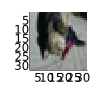

In [155]:
using Plots
conv2image(x) = colorview(RGB, permutedims(x, (3, 2, 1)))
plot(conv2image(train_x[:,:,:,rand(1:end)]), size=(100,100))

In [171]:
using AlgorithmicRecourse, AlgorithmicRecourse.Models
import AlgorithmicRecourse.Models: logits, probs # import functions in order to extend

# Step 1)
struct NeuralNetwork <: Models.FittedModel
    nn::Any
end

# Step 2)
logits(𝑴::NeuralNetwork, X::AbstractArray) = 𝑴.nn(X)
probs(𝑴::NeuralNetwork, X::AbstractArray)= σ.(logits(𝑴, X))
𝑴 = NeuralNetwork(nn);

In [173]:
ŷ = round.(probs(𝑴, train_x)) # predicted class
# ŷ = CIFAR10.trainlabels()[1:1000]
cats = findall(ŷ .== 0)
dogs = findall(ŷ .== 1)
# Plot random samples:
using Plots
Random.seed!(1234)
n_samples = 10
using StatsBase
random_cats = sample(cats, n_samples, replace=false)
random_dogs = sample(dogs, n_samples, replace=false)
# p_list = [plot(conv2image(train_x[:,:,:,i]), size=(100,100), axis=nothing) for i ∈ vcat(random_cats, random_dogs)];

BoundsError: BoundsError: attempt to access 32×32×3×9000 Array{Float32, 4} at index [1:32, 1:32, 1:3, 1, 4231]

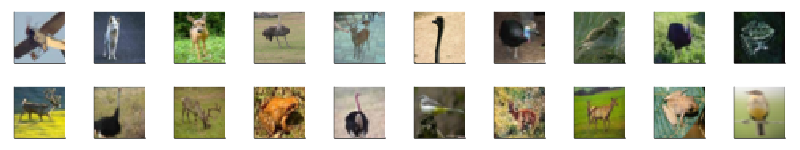

In [122]:
plot(p_list...,layout=(2,n_samples), size=(800,150))